In [1]:
import os
import time
import numpy as np
from sklearn.metrics import r2_score

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
torch.manual_seed(42)

from dataset import E33OMA
from model import Discriminator, Generator, initialize_weights

In [16]:
MODEL="E33OMA-02"
LEARNING_RATE=1.0E-05
NUM_EPOCHS=50
INPUT_SIZE=256
BATCH_SIZE=4
NUM_WORKERS=0
LAMBDA_G=100
BETAS=[0.5, 0.999]
USE_CHECKPOINT = False

SNAPSHOT_DIR = os.path.join('/discover/nobackup/serfani/E33OMA', MODEL, 'snapshots')
RESTORE_FROM = os.path.join('/discover/nobackup/serfani/E33OMA', MODEL, 'snapshots')

try:
    os.makedirs(SNAPSHOT_DIR)
    print(SNAPSHOT_DIR)
except FileExistsError:
    pass

/discover/nobackup/serfani/E33OMA/E33OMA-02/snapshots


In [7]:
def save_checkpoint(model, optimizer, filename, learning_rate=None, epoch=None):

    print('Saving Checkpoint...')
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'learning_rate': learning_rate,
        'epoch': epoch
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer=None, lr=None):
    
    checkpoint = torch.load(checkpoint_file)
    print('Number of Epochs: ', checkpoint['epoch'])
    print('Learning Rate: ', checkpoint['learning_rate'])
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      
        if lr is not None:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        elif checkpoint['learning_rate'] is not None:
            for param_group in optimizer.param_groups:
                param_group['lr'] = checkpoint['learning_rate']

In [ ]:
def val_loop(dataloader, model, saving_path):

    model.eval()
    val_r2 = 0.0
    
    with torch.no_grad():
        for counter, (X, y) in enumerate(dataloader, 1):
            
            # mask = torch.ones_like(y) # (4, 1, 256, 256) -> (4, 1, 90, 144)
            # mask[:, :, 90:, :] = 0.0
            # mask[:, :, :, 144:] = 0.0

            # GPU deployment
            X = X.cuda()
            y = y.cuda()

            # Compute prediction and loss
            pred = model(X)
            pred = pred[:, :, :90, :144]
            
            val_r2 += r2_score(y.detach().cpu().numpy().flatten(), pred.detach().cpu().numpy().flatten())
            # val_r2 += masked_r2_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), mask.detach().cpu().numpy())
            
            # if counter < 5:
            #     save_examples3(ssh, y, pred, transform_params, counter, saving_path)
    
    return val_r2 / len(dataloader)

In [17]:
def main():
    
    since = time.time()
    
    cudnn.enabled = True
    cudnn.benchmark = True
    
    print(f"{MODEL} is deployed on {torch.cuda.get_device_name(0)}")
    
    # Loading model
    generator = Generator(in_channels=5, features=64).cuda()
    
    # Initializing the model weights
    initialize_weights(generator)

#     # Dataloader
#     train_dataset = E33OMA(split='train', padding=256, joint_transform=None)
#     val_dataset   = E33OMA(split='val', padding=256, joint_transform=None)

#     train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     val_dataloader   = DataLoader(val_dataset, batch_size=2, shuffle=True)

    # Initializing the loss function and optimizer
    optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=tuple(BETAS), weight_decay=3.0E-06)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

    loss_func = nn.MSELoss() # reduction='none'
    
    if USE_CHECKPOINT:
        RESTORE_PTH = os.path.join(RESTORE_FROM, 'epoch-00')
        load_checkpoint(f'{RESTORE_PTH}/generator.pth.tar', generator, optimizer, LEARNING_RATE)
    
    logger = {'MSELoss': list(), 'r2_score': list(), 'r2_score_val': list()}
    
    for epoch in range(1, NUM_EPOCHS + 1):
       
        generator.train()

        batch_loss = 0.0
        batch_r2   = 0.0
        
        for batch, (X, y) in enumerate(train_dataloader, 1):
            
            # mask = torch.ones_like(y) # (4, 1, 256, 256) -> (4, 1, 90, 144)
            # mask[:, :, 90:, :] = 0.0
            # mask[:, :, :, 144:] = 0.0
            
            # GPU deployment
            X = X.cuda()
            y = y.cuda()

            # Training Generator            
            pred = generator(X)
            pred = pred[:, :, :90, :144]
            
            # Compute Loss Function
            loss = loss_func(y, pred)
            # loss *= mask
            # loss = loss.sum() / mask.sum()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            batch_loss += loss.item()
            batch_r2   += r2_score(y.detach().cpu().numpy().flatten(), pred.detach().cpu().numpy().flatten())
            # batch_r2   += masked_r2_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), mask.detach().cpu().numpy())

        logger['MSELoss'].append(batch_loss / len(train_dataloader))
        logger['r2_score'].append(batch_r2  / len(train_dataloader))
        
        
        scheduler.step()
        
        logger['r2_score_val'].append(val_loop(val_dataloader, generator, current_epoch_directory))
        
        print(f"Epoch: {epoch}, Loss: {logger['MSELoss'][-1]:.5f}, R2: {logger['r2_score'][-1]:.5f}, R2V: {logger['r2_score_val'][-1]:.5f}")
        
        if epoch % 50 == 0:
            
            current_epoch_directory = os.path.join(SNAPSHOT_DIR, f'epoch-{epoch:003d}')

            try:
                os.makedirs(current_epoch_directory)
            except FileExistsError:
                pass

            print('Learning Rate:', scheduler.get_last_lr())
            save_checkpoint(generator, optimizer,  os.path.join(current_epoch_directory, 'generator.pth.tar'), scheduler.get_last_lr(), epoch)
    
    with open(os.path.join(SNAPSHOT_DIR, "logger.npy"), mode = 'wb') as f:
        np.save(f, np.array(logger['MSELoss']))
        np.save(f, np.array(logger['r2_score']))
        
        np.save(f, np.array(logger['r2_score_val']))
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

In [ ]:
# Dataloader
train_dataset = E33OMA(split='train', padding=256, joint_transform=None)
val_dataset   = E33OMA(split='val', padding=256, joint_transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=2, shuffle=True)

/gpfsm/dhome/serfani/nasa-niswan/dataset.py:45: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds1.indexes['time'].to_datetimeindex()
/gpfsm/dhome/serfani/nasa-niswan/dataset.py:45: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds1.indexes['time'].to_datetimeindex()


In [18]:
main()

E33OMA-02 is deployed on A100-SXM4-40GB
Epoch: 1, Loss: 0.05554, R2: -29.52836, R2V: -0.17788
Epoch: 2, Loss: 0.00180, R2: 0.01996, R2V: 0.23322
Epoch: 3, Loss: 0.00135, R2: 0.26757, R2V: 0.30107
Epoch: 4, Loss: 0.00123, R2: 0.33303, R2V: 0.31566
Epoch: 5, Loss: 0.00116, R2: 0.37284, R2V: 0.31783
Epoch: 6, Loss: 0.00109, R2: 0.40781, R2V: 0.31117
Epoch: 7, Loss: 0.00102, R2: 0.44315, R2V: 0.32277
Epoch: 8, Loss: 0.00095, R2: 0.48293, R2V: 0.33746
Epoch: 9, Loss: 0.00087, R2: 0.52740, R2V: 0.30899
Epoch: 10, Loss: 0.00079, R2: 0.57134, R2V: 0.34521
Epoch: 11, Loss: 0.00072, R2: 0.60916, R2V: 0.37610
Epoch: 12, Loss: 0.00066, R2: 0.64085, R2V: 0.35771
Epoch: 13, Loss: 0.00061, R2: 0.66532, R2V: 0.39754
Epoch: 14, Loss: 0.00057, R2: 0.68676, R2V: 0.37218
Epoch: 15, Loss: 0.00054, R2: 0.70431, R2V: 0.38314
Epoch: 16, Loss: 0.00051, R2: 0.72013, R2V: 0.37779
Epoch: 17, Loss: 0.00049, R2: 0.73461, R2V: 0.37690
Epoch: 18, Loss: 0.00046, R2: 0.74709, R2V: 0.36050
Epoch: 19, Loss: 0.00044, R2: 

In [19]:
with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
    loss = np.load(f)
    R2_train = np.load(f)
    R2_valid = np.load(f)

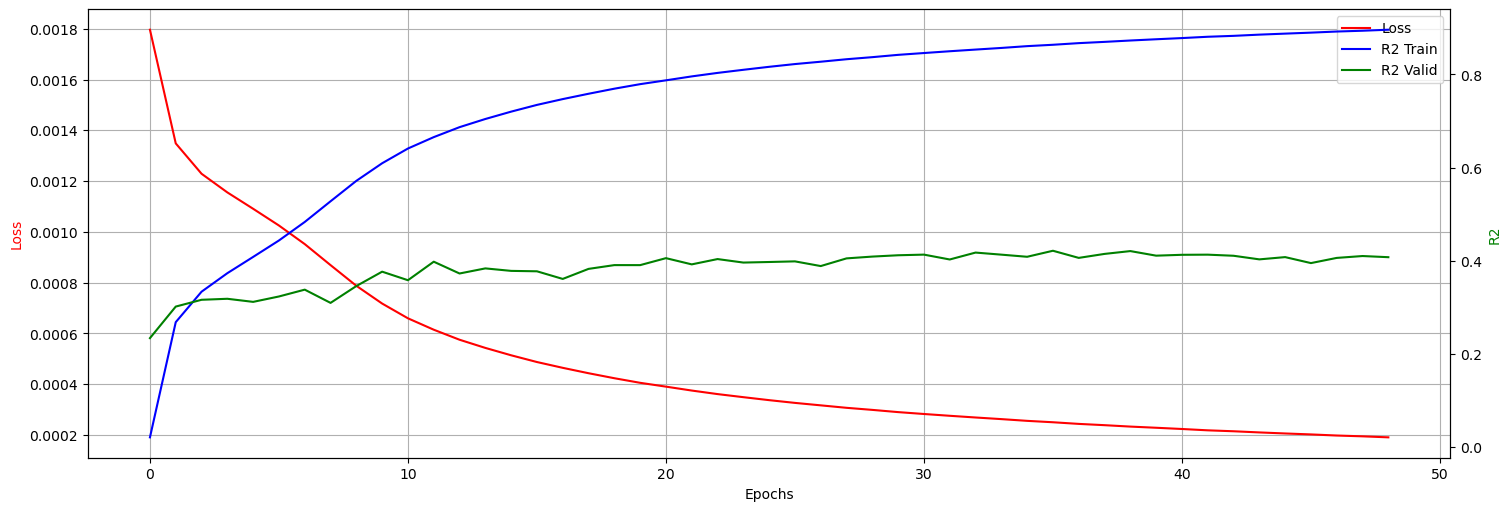

In [92]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 5), constrained_layout=True)

lns1 = ax1.plot(loss[1:], 'r', label='Loss')

ax2 = ax1.twinx()
lns2 = ax2.plot(R2_train[1:], 'b', label='R2 Train')
lns3 = ax2.plot(R2_valid[1:], 'g', label='R2 Valid')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('R2', color='g')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
plt.show()

In [23]:
cudnn.enabled = True
cudnn.benchmark = True

# Loading model
model = Generator(in_channels=5, features=64).cuda()
load_checkpoint(f'{RESTORE_FROM}/epoch-{NUM_EPOCHS:003d}/generator.pth.tar', model)

Number of Epochs:  50
Learning Rate:  [1e-05]


In [22]:
dataset      = E33OMA(split='test', padding=256, joint_transform=None)
dataloader   = DataLoader(dataset, batch_size=1, shuffle=False)

/gpfsm/dhome/serfani/nasa-niswan/dataset.py:45: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds1.indexes['time'].to_datetimeindex()


In [25]:

GTs = np.empty((0, 1, 90, 144))
PDs = np.empty((0, 1, 90, 144))

model.eval()
r2 = list()

with torch.no_grad():
    for counter, (X, y) in enumerate(dataloader, 1):

        # GPU deployment
        X = X.cuda()
        y = y.cuda()

        # Compute prediction and loss
        pred = model(X)
        pred = pred[:, :, :90, :144]
        
        y    = (y.detach().cpu().numpy() + 1) / 2
        pred = (pred.detach().cpu().numpy() + 1) / 2
        
        y    = y    * (dataset.target_max - dataset.target_min) + dataset.target_min
        pred = pred * (dataset.target_max - dataset.target_min) + dataset.target_min
        
        r2.append(r2_score(y.flatten(), pred.flatten()))
        
        GTs = np.concatenate((GTs, y), axis=0)
        PDs = np.concatenate((PDs, pred), axis=0)
        
print(GTs.shape, PDs.shape)

(865, 1, 90, 144) (865, 1, 90, 144)


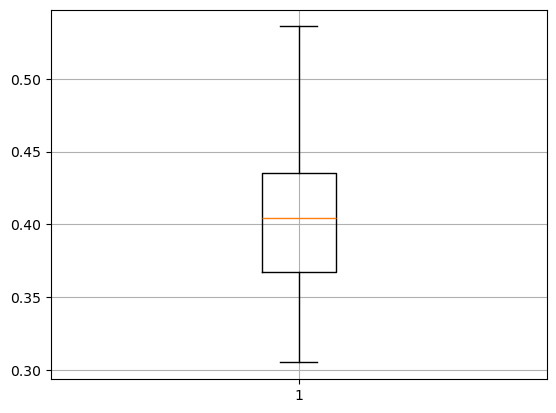

In [31]:
import xarray as xr
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(np.array(r2))

plt.grid()
plt.show()

In [85]:
r_squared = np.empty((GTs.shape[2], GTs.shape[3]))

for i in range(GTs.shape[2]):
    for j in range(GTs.shape[3]):
        r_squared[i, j] = r2_score(GTs[:, 0, i, j], PDs[:, 0, i, j])
        

In [45]:
for root, dirs, files in os.walk('/discover/nobackup/sebauer1/E33oma_ai/output/'):

    sorted_files = sorted(files)
    files_list = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijlh1E33oma_ai']

ds = xr.open_mfdataset(files_list)
ds = ds.isel(level=0).drop_vars('level')
ds = ds.drop_vars(['axyp', 'Clay', 'BCB'])

In [ ]:
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [49]:
ds

<xarray.Dataset>
Dimensions:   (lon: 144, lat: 90, time: 4320)
Coordinates:
  * lon       (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat       (lat) float32 -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * time      (time) datetime64[ns] 1950-01-01T00:15:00 ... 1950-03-31T23:45:00
Data variables:
    seasalt1  (time, lat, lon) float32 dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E33oma_ai (OMA rundeck purely for initial coding of washout/aqc...

In [82]:
ds1 = xr.Dataset({
    'GT': (["time", "lat", "lon"], GTs.squeeze()),
    'M1': (["time", "lat", "lon"], PDs.squeeze()),
    'R2': (["lat", "lon"], r_squared),

              },
     coords=dict(
        time=ds['time'][3455:],
        lon=ds['lon'].values,
        lat=ds['lat'].values
    )
)
ds1

<xarray.Dataset>
Dimensions:  (time: 865, lat: 90, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1950-03-13T23:45:00 ... 1950-03-31T23:45:00
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat      (lat) float32 -90.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 90.0
Data variables:
    GT       (time, lat, lon) float64 0.06547 0.06547 0.06547 ... 0.1514 0.1514
    M1       (time, lat, lon) float64 0.5375 0.1669 0.17 ... 0.09454 0.09065
    R2       (lat, lon) float64 -467.3 -13.82 -14.9 ... -2.271 -2.887 -1.911

In [104]:
ds1.to_netcdf('/discover/nobackup/serfani/E33OMA/E33OMA-02/test-results.nc')

In [42]:
import geopandas as gpd

# Load the world shapefile provided by geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/gpfsm/dnb33/tdirs/batch/slurm.30434818.serfani/ipykernel_23950/3104629042.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


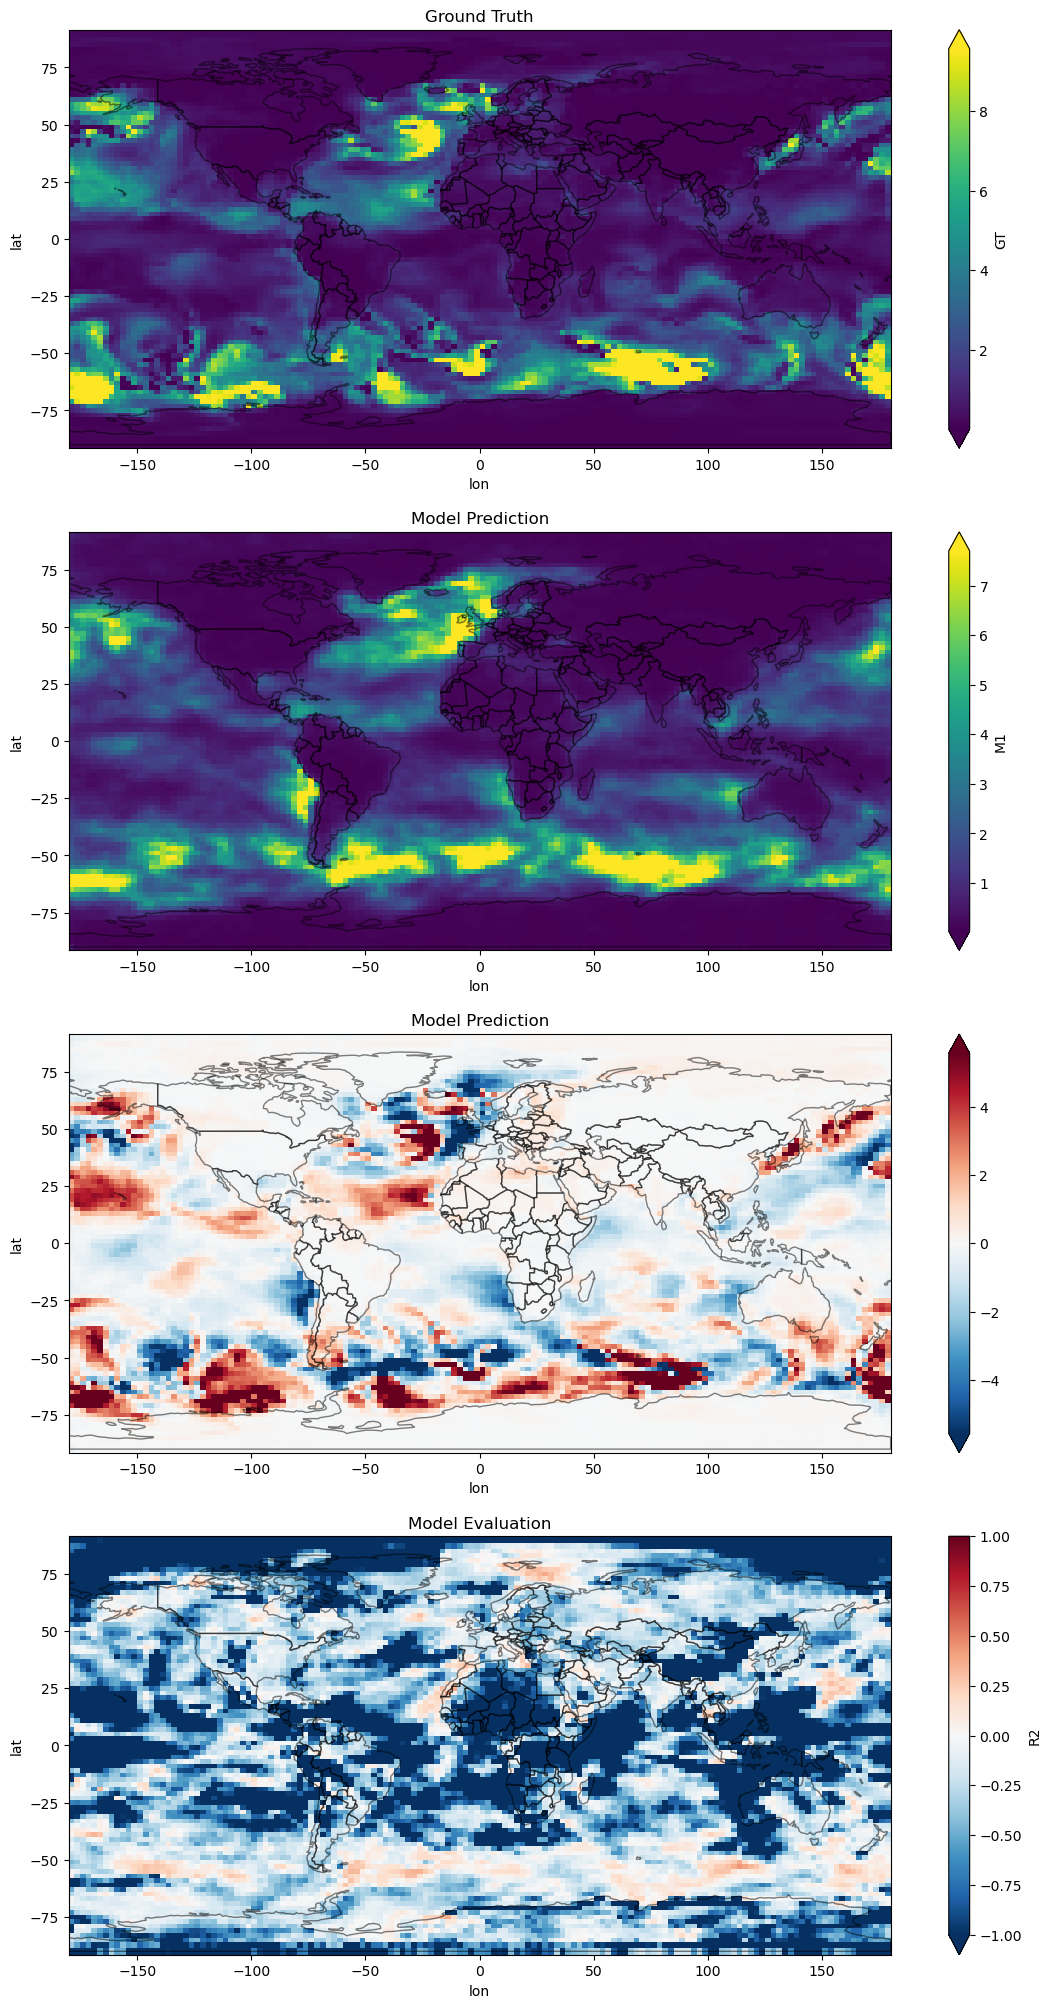

In [91]:
idx = 50
fig, axs = plt.subplots(nrows=4, figsize=(15, 25))

ds1['GT'].isel(time=idx).plot(ax=axs[0], robust=True)
world.plot(ax=axs[0], color='none', alpha=0.5, edgecolor='#000000', linewidth=1.0)
axs[0].set_title('Ground Truth')

ds1['M1'].isel(time=idx).plot(ax=axs[1], robust=True)
world.plot(ax=axs[1], color='none', alpha=0.5, edgecolor='#000000', linewidth=1.0)
axs[1].set_title('Model Prediction')

(ds1['GT'].isel(time=idx) - ds1['M1'].isel(time=idx)).plot(ax=axs[2], robust=True)
world.plot(ax=axs[2], color='none', alpha=0.5, edgecolor='#000000', linewidth=1.0)
axs[2].set_title('Model Prediction')

ds1['R2'].plot(ax=axs[3], robust=True, vmax=1.0)
world.plot(ax=axs[3], color='none', alpha=0.5, edgecolor='#000000', linewidth=1.0)
axs[3].set_title('Model Evaluation')
plt.show()

In [93]:
df = ds1.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
df.head()

,lat,lon,time,GT,M1,R2
0,-90.0,-178.75,1950-03-13 23:45:00,0.065472,0.537520,-467.280452
1,-90.0,-178.75,1950-03-14 00:15:00,0.066167,0.535206,-467.280452
2,-90.0,-178.75,1950-03-14 00:45:00,0.066873,0.530847,-467.280452
3,-90.0,-178.75,1950-03-14 01:15:00,0.067553,0.525105,-467.280452
4,-90.0,-178.75,1950-03-14 01:45:00,0.067973,0.515277,-467.280452


In [94]:
gdf = df.groupby(['lat', 'lon'])
for co, _ in gdf:
    print(co)

(-90.0, -178.75)
(-90.0, -176.25)
(-90.0, -173.75)
(-90.0, -171.25)
(-90.0, -168.75)
(-90.0, -166.25)
(-90.0, -163.75)
(-90.0, -161.25)
(-90.0, -158.75)
(-90.0, -156.25)
(-90.0, -153.75)
(-90.0, -151.25)
(-90.0, -148.75)
(-90.0, -146.25)
(-90.0, -143.75)
(-90.0, -141.25)
(-90.0, -138.75)
(-90.0, -136.25)
(-90.0, -133.75)
(-90.0, -131.25)
(-90.0, -128.75)
(-90.0, -126.25)
(-90.0, -123.75)
(-90.0, -121.25)
(-90.0, -118.75)
(-90.0, -116.25)
(-90.0, -113.75)
(-90.0, -111.25)
(-90.0, -108.75)
(-90.0, -106.25)
(-90.0, -103.75)
(-90.0, -101.25)
(-90.0, -98.75)
(-90.0, -96.25)
(-90.0, -93.75)
(-90.0, -91.25)
(-90.0, -88.75)
(-90.0, -86.25)
(-90.0, -83.75)
(-90.0, -81.25)
(-90.0, -78.75)
(-90.0, -76.25)
(-90.0, -73.75)
(-90.0, -71.25)
(-90.0, -68.75)
(-90.0, -66.25)
(-90.0, -63.75)
(-90.0, -61.25)
(-90.0, -58.75)
(-90.0, -56.25)
(-90.0, -53.75)
(-90.0, -51.25)
(-90.0, -48.75)
(-90.0, -46.25)
(-90.0, -43.75)
(-90.0, -41.25)
(-90.0, -38.75)
(-90.0, -36.25)
(-90.0, -33.75)
(-90.0, -31.25)
(-90.0, 

In [98]:
g = gdf.get_group((-90.0, -128.75))

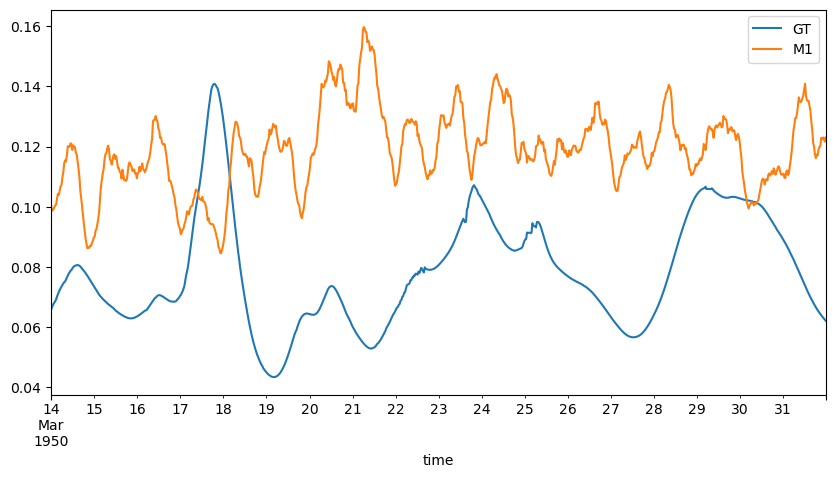

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
g.set_index('time')[['GT', 'M1']].plot(ax=ax)
plt.show()